# 1. Генератор чисел Фибоначчи


Числа Фибоначчи - это последовательность, где каждое число является суммой двух предыдущих.

1. Генератор начинает с первых двух чисел последовательности: 0 и 1.
2. В цикле он выдает текущее число и вычисляет следующее, складывая два предыдущих.
3. Этот процесс повторяется n раз, создавая первые n чисел Фибоначчи.

In [1]:
def fibonacci_generator(n):
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b

n = 10
for num in fibonacci_generator(n):
              print(num)

0
1
1
2
3
5
8
13
21
34


# 2. SQL запросы

Решение пункта 1.

        SELECT d.name
        FROM Department d
            JOIN Personal p ON d.Id = p.Id_dep
        GROUP BY d.name
        ORDER BY COUNT(p.Id) DESC
        LIMIT 1;

Этот запрос выбирает название отдела (d.name), который имеет наибольшее количество сотрудников, используя соединение таблиц Department и Personal (таблица Department хранит информацию об отделах, а Personal информацию о сотрудниках, в которой указано, к какому отделу относится сотрудник). Группировка производится по названиям отделов, затем применяется сортировка по количеству сотрудников в порядке убывания, а ограничение LIMIT 1 возвращает только один отдел с наибольшим числом сотрудников.  

Решение пункта 2.

        SELECT p1.name
        FROM Personal p1
            JOIN Personal p2 ON p1.Id_head = p2.Id
        WHERE p1.sal > p2.sal;

Этот запрос выбирает сотрудников, чья заработная плата больше, чем у их руководителей, используя самосоединение таблицы Personal, где p1 — сотрудник, p2 — его руководитель, а условие WHERE проверяет, что зарплата сотрудника больше зарплаты его руководителя.

Для проверки построим таблицы с приведенной в задании информацией и посмотрим на результат выполнения запроса.

In [2]:
import sqlite3

# Cоздаём базу данных в оперативной памяти для дальнейшего тестирования. 
# После завершения работы память будет освобождена.
conn = sqlite3.connect(':memory:')

# Создаём объект cursor, который используется для выполнения SQL-запросов.
cursor = conn.cursor()

# executescript позволяет выполнить создание и вставку данных в табоицу одной командой.
cursor.executescript('''
-- Создание таблицы Department
CREATE TABLE Department (
    id INT PRIMARY KEY,
    name VARCHAR(255) NOT NULL
);

-- Создание таблицы Personal
CREATE TABLE Personal (
    id INT PRIMARY KEY,
    id_head INT,
    id_dep INT NOT NULL,
    name VARCHAR(255) NOT NULL,
    sal INT NOT NULL,
    FOREIGN KEY (id_head) REFERENCES Personal(id), -- id_head – id – руководителя
    FOREIGN KEY (id_dep) REFERENCES Department(id) -- id_dep – id департамента
);

-- Заполнение таблицы Department
INSERT INTO Department (id, name) VALUES
(1, 'Финансы'),
(2, 'Риски'),
(3, 'Розница'),
(4, 'Безопасность'),
(1000, 'ДКК');

-- Заполнение таблицы Personal
INSERT INTO Personal (id, id_head, id_dep, name, sal) VALUES
(1, 1, 2, 'Бегинс', 45000),
(2, 1, 2, 'Поттер', 80000),
(3, 2, 2, 'Чапаев', 100000),
(4, 4, 4, 'Шилов', 65000),
(10000, 5, 3, 'Наумов', 64500);
''')

# Выполнение запросов
queries = {
    "Отдел с наибольшим числом сотрудников": '''
        SELECT d.name
        FROM Department d
            JOIN Personal p ON d.Id = p.Id_dep
        GROUP BY d.name
        ORDER BY COUNT(p.Id) DESC
        LIMIT 1;
    ''',
    "Сотрудники, получающие заработную плату выше, чем у руководителя": '''
        SELECT p1.name
        FROM Personal p1
            JOIN Personal p2 ON p1.Id_head = p2.Id
        WHERE p1.sal > p2.sal;
    '''
}

# Цикл проходит по всем запросам в словаре.
# Каждый SQL-запрос выполняется с помощью cursor.execute(query).
for query_name, query in queries.items():
    print(f"{query_name}:")
    for row in cursor.execute(query):
        print(row)
    print()

# Удаляем временную базу данных, созданную в оперативной памяти.
conn.close()

Отдел с наибольшим числом сотрудников:
('Риски',)

Сотрудники, получающие заработную плату выше, чем у руководителя:
('Поттер',)
('Чапаев',)



# 3. Задачка на определение отрасли компании


## 1. Подготовка данных

### 1.1 Загрузка данных

У нас есть 2 таблицы: pays и inn_info_public. Во второй представлена информация о компаниях, в первой информация о транзакциях между этими компаниями.

In [3]:
import pandas as pd
import numpy as np

# Загружаем две таблицы: pays и inn_info_public
pays = pd.read_csv("./TestCase-Industry/pays.csv")
inn_info_public = pd.read_csv("./TestCase-Industry/inn_info_public.csv")

print("Таблица Pays:")
print(pays.head())

print("\nТаблица inn_info_public:")
print(inn_info_public.head())

Таблица Pays:
   hash_inn_kt  hash_inn_dt  week  count      sum
0            0            0     1      4  38399.6
1            0            0     5      2    399.6
2            0            0     7      2     79.6
3            0            0     9      2    239.6
4            0            0    12      2     79.6

Таблица inn_info_public:
   hash_inn  okved2  region  is_public
0     61058      34      86       True
1      8311      18      86       True
2    130273      -1      86      False
3     64081      43      86       True
4    218005      12      86       True


### 1.2 Исследование данных

Чтобы лучше понять особенности рассматриваемых данных, выведем некоторые статистики, рассмотрим варианты значений отраслей, а так же их распределение.


Описание данных pays:
        hash_inn_kt   hash_inn_dt          week         count           sum
count  5.430150e+06  5.430150e+06  5.430150e+06  5.430150e+06  5.429025e+06
mean   1.288775e+05  1.305203e+05  1.161926e+01  2.919462e+00  3.939404e+02
std    7.569651e+04  7.564641e+04  6.332949e+00  5.050308e+00  7.259421e+03
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -4.000000e-01
25%    6.292900e+04  6.476100e+04  6.000000e+00  1.000000e+00  3.280000e+00
50%    1.273810e+05  1.295880e+05  1.200000e+01  2.000000e+00  1.456800e+01
75%    1.943850e+05  1.966060e+05  1.700000e+01  3.000000e+00  6.920000e+01
max    2.605110e+05  2.605150e+05  2.300000e+01  2.530000e+03  3.966400e+06

Описание данных inn_info_public:
            hash_inn         okved2         region
count  240069.000000  240069.000000  240069.000000
mean   130236.418734      18.771803      58.938343
std     75201.512046      22.078592      26.935958
min         0.000000      -1.000000       0.000000
25% 

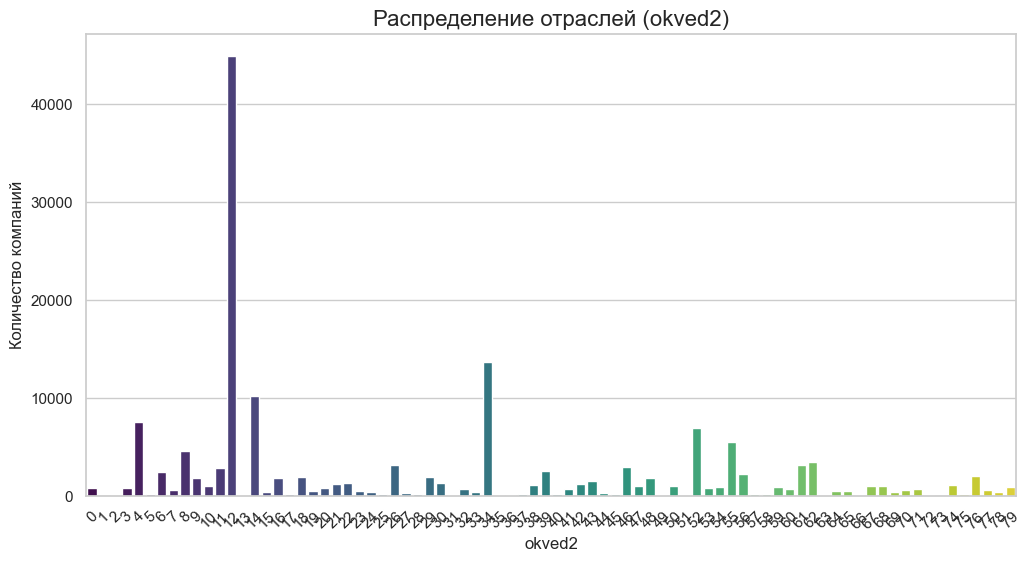

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

print("\nОписание данных pays:")
print(pays.describe())

print("\nОписание данных inn_info_public:")
print(inn_info_public.describe())

# Распределение значений okved2 по компаниям (исключая -1)
plt.figure(figsize=(12, 6))
sns.countplot(data=inn_info_public[inn_info_public["okved2"] != -1], x="okved2", palette="viridis")
plt.title("Распределение отраслей (okved2)", fontsize=16)
plt.xlabel("okved2", fontsize=12)
plt.ylabel("Количество компаний", fontsize=12)
plt.xticks(rotation=45)
plt.show()

Можно заметить, что часто встречаются отрасли 12, 34, 14, 4, 52.

### 1.3 Объединение данных

Теперь нужно добавить данные из таблицы pays в inn_info_public, на основе первой таблицы каждую компанию из второй таблицы по ИНН можно охарактеризовать как получателя и как отправителя, а так же добавить информацию о том, с кем компания осуществляла взаимодействия. Важно заметить, что в таблице pays для каждой транзакции указан номер недели, значит транзакции каждой компании можно упорядочить по времени и представить в виде временного ряда. Соединим таблицы и визуализируем некоторые данные.

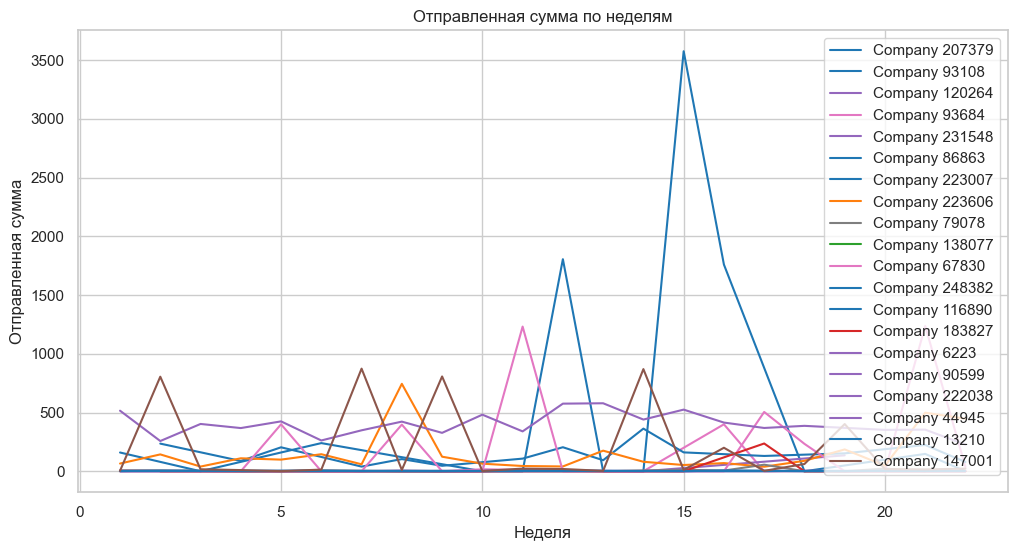

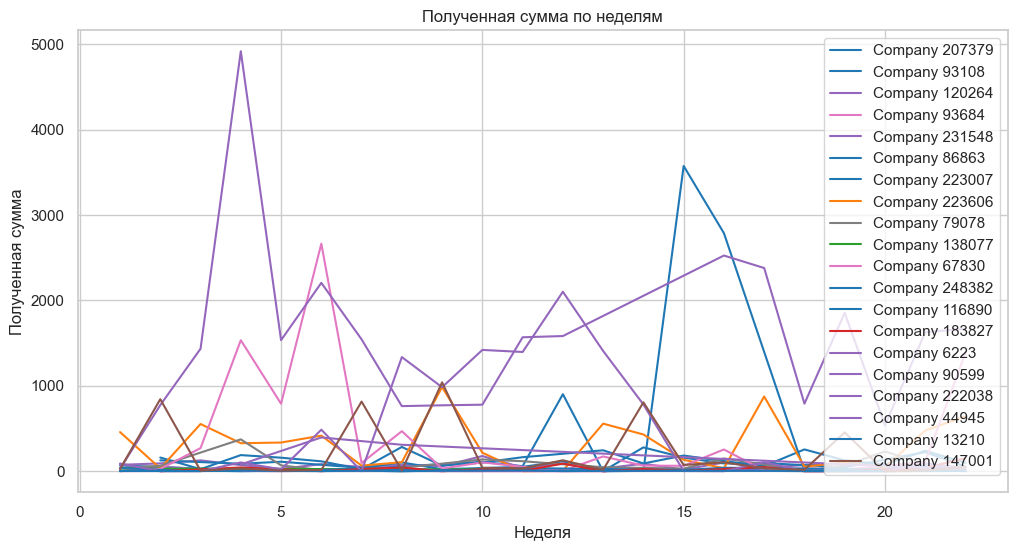

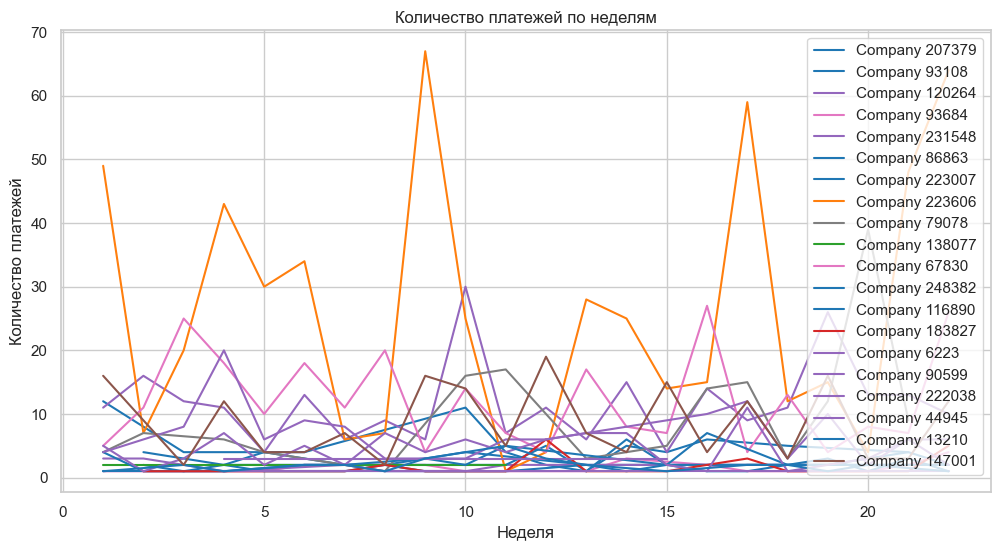

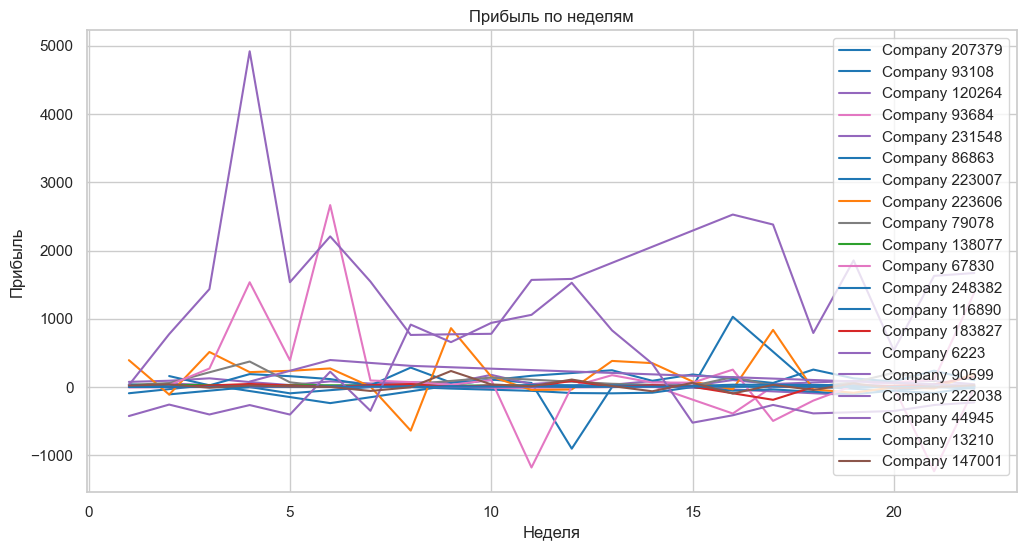

In [5]:
# Агрегируем данные по hash_inn, каждую компанию хотим охарактеризовать как получателя и как отправителя
pays_grouped_by_receiver = pays.groupby(['hash_inn_dt', 'week']).agg(
    received_sum=('sum', lambda x: x.abs().sum()),  # Используем модуль суммы
    received_count=('count', 'sum'),
    senders=('hash_inn_kt', lambda x: list(x.unique()))  # Собираем уникальных отправителей
).reset_index()
pays_grouped_by_receiver.rename(columns={'hash_inn_dt': 'hash_inn'}, inplace=True)

pays_grouped_by_sender = pays.groupby(['hash_inn_kt', 'week']).agg(
    sent_sum=('sum', lambda x: x.abs().sum()),  # Используем модуль суммы
    sent_count=('count', 'sum'),
    receivers=('hash_inn_dt', lambda x: list(x.unique()))  # Собираем уникальных получателей
).reset_index()
pays_grouped_by_sender.rename(columns={'hash_inn_kt': 'hash_inn'}, inplace=True)

# Объединяем информацию по компаниям
combined = pd.merge(
    inn_info_public, 
    pays_grouped_by_receiver, 
    on='hash_inn', 
    how='left'
)

combined = pd.merge(
    combined, 
    pays_grouped_by_sender, 
    on=['hash_inn', 'week'], 
    how='left'
)

# Заполняем пропуски нулями
combined.fillna({'received_sum': 0, 'sent_sum': 0, 'received_count': 0, 'sent_count': 0}, inplace=True)

# Заполняем пропуски для списков
combined['senders'] = combined['senders'].apply(lambda x: x if isinstance(x, list) else [])
combined['receivers'] = combined['receivers'].apply(lambda x: x if isinstance(x, list) else [])

# Добавляем прибыль как разницу между полученной и отправленной суммой
combined['profit'] = combined['received_sum'] - combined['sent_sum']


# Поскольку информация о транзакциях дана по неделям, по сути мы имеем дело с временными рядами.
# Визуализируем несколько показателей по неделям у некоторого сэмпла компаний.
sample_companies = combined['hash_inn'].sample(20, random_state=42).unique()
sample_data = combined[combined['hash_inn'].isin(sample_companies)]

# Цвет кривой будет показывать отрасль okved2.
palette = sns.color_palette('tab10', n_colors=sample_data['okved2'].nunique())
class_color_map = {okved2: color for okved2, color in zip(sample_data['okved2'].unique(), palette)}

# График 1: Отправленная сумма
plt.figure(figsize=(12, 6))
for inn in sample_companies:
    company_data = sample_data[sample_data['hash_inn'] == inn]
    plt.plot(company_data['week'], company_data['sent_sum'], label=f'Company {inn}',
             color=class_color_map[company_data['okved2'].iloc[0]])
plt.title('Отправленная сумма по неделям')
plt.xlabel('Неделя')
plt.ylabel('Отправленная сумма')
plt.legend()
plt.show()

# График 2: Полученная сумма
plt.figure(figsize=(12, 6))
for inn in sample_companies:
    company_data = sample_data[sample_data['hash_inn'] == inn]
    plt.plot(company_data['week'], company_data['received_sum'], label=f'Company {inn}',
             color=class_color_map[company_data['okved2'].iloc[0]])
plt.title('Полученная сумма по неделям')
plt.xlabel('Неделя')
plt.ylabel('Полученная сумма')
plt.legend()
plt.show()

# График 3: Количество платежей
plt.figure(figsize=(12, 6))
for inn in sample_companies:
    company_data = sample_data[sample_data['hash_inn'] == inn]
    plt.plot(company_data['week'], company_data['received_count'], label=f'Company {inn}',
             color=class_color_map[company_data['okved2'].iloc[0]])
plt.title('Количество платежей по неделям')
plt.xlabel('Неделя')
plt.ylabel('Количество платежей')
plt.legend()
plt.show()

# График 4: Прибыль (полученная сумма - отправленная сумма)
plt.figure(figsize=(12, 6))
for inn in sample_companies:
    company_data = sample_data[sample_data['hash_inn'] == inn]
    plt.plot(company_data['week'], company_data['profit'], label=f'Company {inn}',
             color=class_color_map[company_data['okved2'].iloc[0]])
plt.title('Прибыль по неделям')
plt.xlabel('Неделя')
plt.ylabel('Прибыль')
plt.legend()
plt.show()

In [6]:
# Посмотрим как выглядят получившиеся объекты на примере одного hash_inn.
combined[combined['hash_inn'] == 230402]

,hash_inn,okved2,region,is_public,week,received_sum,received_count,senders,sent_sum,sent_count,receivers,profit
1608543,230402,12,12,True,1.0,417.520,12.0,[120697],151.600,3.0,[179429],265.920
1608544,230402,12,12,True,2.0,548.908,12.0,[120697],139.600,4.0,[179429],409.308
1608545,230402,12,12,True,3.0,66.688,3.0,[120697],55.600,2.0,[179429],11.088
1608546,230402,12,12,True,4.0,407.904,12.0,[120697],559.200,5.0,"[155536, 179429]",-151.296
1608547,230402,12,12,True,5.0,113.904,6.0,[120697],243.600,5.0,[179429],-129.696
1608548,230402,12,12,True,6.0,637.136,9.0,[120697],119.600,3.0,[179429],517.536
1608549,230402,12,12,True,7.0,539.600,3.0,[120697],102.592,3.0,[179429],437.008
1608550,230402,12,12,True,8.0,526.784,12.0,[120697],83.200,2.0,[179429],443.584
1608551,230402,12,12,True,9.0,35.324,3.0,[120697],99.600,2.0,[179429],-64.276
1608552,230402,12,12,True,10.0,63.236,3.0,[120697],39.600,2.0,[179429],23.636


### 1.4 Группировка данных

Поскольку на предыдущем этапе в результирующей таблице получалось много строк с одним ИНН, то для расчета в дальнейшем новых информативных признаков удобно сначала сгруппировать данные по ИНН, чтобы по каждому ИНН вся информация была в одном объекте, на основе получившейся после группировки таблицы будет удобно сагрегировать новые фичи, объединяющие всю информацию.

In [7]:
combined = combined.drop(columns=['is_public'])

# Группируем данные по hash_inn, сохраняя okved2 и region, и преобразуем последние столбцы в массивы
result = combined.groupby('hash_inn').agg({
    'okved2': 'first',
    'region': 'first',
    'week': list,
    'received_sum': list,
    'received_count': list,
    'sent_sum': list,
    'sent_count': list,
    'profit': list,
    'senders': lambda x: list(set().union(*x)),  # Объединяем списки отправителей
    'receivers': lambda x: list(set().union(*x))  # Объединяем списки получателей
}).reset_index()

# Посмотрим как выглядят получившиеся объекты на примере одного.
print(result[result['hash_inn'] == 230402])

        hash_inn  okved2  region  \
212344    230402      12      12   

                                                     week  \
212344  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   

                                             received_sum  \
212344  [417.52, 548.908, 66.688, 407.904, 113.904, 63...   

                                           received_count  \
212344  [12.0, 12.0, 3.0, 12.0, 6.0, 9.0, 3.0, 12.0, 3...   

                                                 sent_sum  \
212344  [151.6, 139.6, 55.6, 559.2, 243.6, 119.6, 102....   

                                               sent_count  \
212344  [3.0, 4.0, 2.0, 5.0, 5.0, 3.0, 3.0, 2.0, 2.0, ...   

                                                   profit           senders  \
212344  [265.91999999999996, 409.308, 11.0880000000000...  [120697, 141731]   

                       receivers  
212344  [155536, 120697, 179429]  


In [8]:
# Названия колонок результирующей таблицы.
result.columns.tolist()

['hash_inn',
 'okved2',
 'region',
 'week',
 'received_sum',
 'received_count',
 'sent_sum',
 'sent_count',
 'profit',
 'senders',
 'receivers']

### 1.5 Агрегация новых признаков

Сначала сгенерируем типичные признаки, характеризующие временные ряды: среднее, медиану,минимум, максимум, стандартное отклонение.

In [9]:
# Посчитаем различные статистики
features = result.apply(lambda row: pd.Series({
    'received_sum_mean': np.mean(row['received_sum']),
    'received_sum_median': np.median(row['received_sum']),
    'received_sum_min': np.min(row['received_sum']),
    'received_sum_max': np.max(row['received_sum']),
    'received_sum_std': np.std(row['received_sum']),
    
    'received_count_mean': np.mean(row['received_count']),
    'received_count_median': np.median(row['received_count']),
    'received_count_min': np.min(row['received_count']),
    'received_count_max': np.max(row['received_count']),
    'received_count_std': np.std(row['received_count']),
    
    'sent_sum_mean': np.mean(row['sent_sum']),
    'sent_sum_median': np.median(row['sent_sum']),
    'sent_sum_min': np.min(row['sent_sum']),
    'sent_sum_max': np.max(row['sent_sum']),
    'sent_sum_std': np.std(row['sent_sum']),
    
    'sent_count_mean': np.mean(row['sent_count']),
    'sent_count_median': np.median(row['sent_count']),
    'sent_count_min': np.min(row['sent_count']),
    'sent_count_max': np.max(row['sent_count']),
    'sent_count_std': np.std(row['sent_count']),
    
    'profit_mean': np.mean(row['profit']),
    'profit_median': np.median(row['profit']),
    'profit_min': np.min(row['profit']),
    'profit_max': np.max(row['profit']),
    'profit_std': np.std(row['profit']),
    
    'unique_senders_count': len(set(row['senders'])),
    'unique_receivers_count': len(set(row['receivers']))
}), axis=1)

final_result = pd.concat([result[['hash_inn', 'okved2', 'region']], features], axis=1)

# Посмотрим как выглядят получившиеся объекты на примере одного.
print(final_result[final_result['hash_inn'] == 230402])

        hash_inn  okved2  region  received_sum_mean  received_sum_median  \
212344    230402      12      12         375.214667               417.52   

        received_sum_min  received_sum_max  received_sum_std  \
212344            35.324             839.6        270.324032   

        received_count_mean  received_count_median  ...  sent_count_min  \
212344                  6.4                    3.0  ...             0.0   

        sent_count_max  sent_count_std  profit_mean  profit_median  \
212344             5.0        1.339983      148.404          119.6   

        profit_min  profit_max  profit_std  unique_senders_count  \
212344     -404.44     517.536  279.191503                   2.0   

        unique_receivers_count  
212344                     3.0  

[1 rows x 30 columns]


In [10]:
# Названия колонок результирующей таблицы
final_result.columns.tolist()

['hash_inn',
 'okved2',
 'region',
 'received_sum_mean',
 'received_sum_median',
 'received_sum_min',
 'received_sum_max',
 'received_sum_std',
 'received_count_mean',
 'received_count_median',
 'received_count_min',
 'received_count_max',
 'received_count_std',
 'sent_sum_mean',
 'sent_sum_median',
 'sent_sum_min',
 'sent_sum_max',
 'sent_sum_std',
 'sent_count_mean',
 'sent_count_median',
 'sent_count_min',
 'sent_count_max',
 'sent_count_std',
 'profit_mean',
 'profit_median',
 'profit_min',
 'profit_max',
 'profit_std',
 'unique_senders_count',
 'unique_receivers_count']

Далее сгененируем более сложные признаки, такие как тренд, оконные функции, лаги.

In [11]:
from numpy.polynomial.polynomial import Polynomial

def extract_time_series_features(series):
    # Преобразуем в Pandas Series
    ts = pd.Series(series)
    
    # Полиномиальный тренд
    if len(ts) > 1:
        p = Polynomial.fit(range(len(ts)), ts, deg=1)
        trend = p(range(len(ts)))
    else:
        trend = np.array([0]) # Если данных меньше двух
    
    # Скользящее среднее с окном 3
    rolling_mean = ts.rolling(window=3, min_periods=1).mean()
    
    # Лаги
    lag_1 = ts.shift(1).fillna(0).iloc[-1] if len(ts) > 1 else 0
    lag_2 = ts.shift(2).fillna(0).iloc[-1] if len(ts) > 2 else 0
    
    return {
        'trend_mean': np.mean(trend),
        'trend_std': np.std(trend),
        'rolling_mean_last': rolling_mean.iloc[-1],
        'lag_1': lag_1,
        'lag_2': lag_2
    }

# Вспомогательная функция для подсчета статистик
def extract_all_features(row, column_name):
    features = extract_time_series_features(row[column_name])
    return {
        f'{column_name}_trend_mean': features['trend_mean'],
        f'{column_name}_trend_std': features['trend_std'],
        f'{column_name}_rolling_mean_last': features['rolling_mean_last'],
        f'{column_name}_lag_1': features['lag_1'],
        f'{column_name}_lag_2': features['lag_2'],
    }

# Применяем функцию к каждому из временных рядов
time_series_features = result.apply(lambda row: pd.Series({
    **extract_all_features(row, 'received_sum'),
    **extract_all_features(row, 'received_count'),
    **extract_all_features(row, 'sent_sum'),
    **extract_all_features(row, 'sent_count'),
    **extract_all_features(row, 'profit')
}), axis=1)

extended_result = pd.concat([final_result, time_series_features], axis=1)

# Сохранение таблицы в файл CSV
extended_result.to_csv('result.csv', index=False)

# Посмотрим как выглядят получившиеся объекты на примере одного.
print(extended_result[extended_result['hash_inn'] == 230402])

        hash_inn  okved2  region  received_sum_mean  received_sum_median  \
212344    230402      12      12         375.214667               417.52   

        received_sum_min  received_sum_max  received_sum_std  \
212344            35.324             839.6        270.324032   

        received_count_mean  received_count_median  ...  \
212344                  6.4                    3.0  ...   

        sent_count_trend_mean  sent_count_trend_std  \
212344               2.733333              0.802377   

        sent_count_rolling_mean_last  sent_count_lag_1  sent_count_lag_2  \
212344                      1.333333               1.0               3.0   

        profit_trend_mean  profit_trend_std  profit_rolling_mean_last  \
212344            148.404         18.627068                324.429333   

        profit_lag_1  profit_lag_2  
212344       489.288         364.4  

[1 rows x 55 columns]


In [12]:
# Загрузка таблицы из файла CSV
extended_result = pd.read_csv('result.csv')

print(extended_result.head())

   hash_inn  okved2  region  received_sum_mean  received_sum_median  \
0         0      -1      84          7819.6340             3056.692   
1         1      62      26             0.0000                0.000   
2         2      -1      58            42.7484               30.704   
3         3      29      60             0.0000                0.000   
4         4      -1      17             0.0000                0.000   

   received_sum_min  received_sum_max  received_sum_std  received_count_mean  \
0           130.252         55733.724      13034.438683            48.954545   
1             0.000             0.000          0.000000             0.000000   
2             4.436           110.480         32.190740             2.900000   
3             0.000             0.000          0.000000             0.000000   
4             0.000             0.000          0.000000             0.000000   

   received_count_median  ...  sent_count_trend_mean  sent_count_trend_std  \
0             

## 2. Обучение моделей


На полученных данных обучим несколько сильных моделей и выберем ту, которая покажет лучшее качество.

In [13]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

# Отделяем тестовую выборку.
extended_result['region'] = extended_result['region'].astype('category')
test_data = extended_result[extended_result['okved2'] == -1]
train_val_data = extended_result[extended_result['okved2'] != -1]

# Определяем признаки и таргет
features = [col for col in train_val_data.columns if col not in ['hash_inn', 'okved2']]
target = 'okved2'

# Разделяем остальные данные на обучающую и валидационную выборки
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_ind, val_ind = next(splitter.split(train_val_data[features], train_val_data[target]))
train_data = train_val_data.iloc[train_ind]
val_data = train_val_data.iloc[val_ind]

### 2.1 LightGBM

In [14]:
# Подготавливаем данные для последующей подачи в модель
train_dataset = lgb.Dataset(train_data[features], label=train_data[target], categorical_feature=['region'])
val_dataset = lgb.Dataset(val_data[features], label=val_data[target], reference=train_dataset)

# Задаем параметры модели
params = {
    'objective': 'multiclass',
    'num_class': train_val_data[target].nunique(),
    'metric': None,
    'learning_rate': 0.05,
    'num_leaves': 50,
    'max_depth': 7,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'verbose': -1
}

# Поскольку классы несбалансированные, добавим метрику качества balanced accuracy
def custom_accuracy(preds, data):
    label = data.get_label()
    balanced_acc = balanced_accuracy_score(label, np.argmax(preds, axis=1))
    return "balanced acc", balanced_acc, True

# Обучаем модель
model_lgb = lgb.train(
    params,
    train_dataset,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'val'],
    num_boost_round=200,
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

# Оцениваем качество модели на валидационной выборке
val_predictions = model_lgb.predict(val_data[features])
val_predictions = [np.argmax(pred) for pred in val_predictions]
accuracy = accuracy_score(val_data[target], val_predictions)
balanced_accuracy = balanced_accuracy_score(val_data[target], val_predictions)
f_score_weighted = f1_score(val_data[target], val_predictions, average='weighted')
print(f'Validation Accuracy: {accuracy}, balanced accuracy: {balanced_accuracy}, weighted F-score: {f_score_weighted}')

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	train's multi_logloss: 2.29881	val's multi_logloss: 3.01937
Validation Accuracy: 0.309853483257442, balanced accuracy: 0.02570174620683822, weighted F-score: 0.18828070956928836


### 2.2 XGBoost

In [15]:
# Подготавливаем данные для последующей подачи в модель
train_dataset = xgb.DMatrix(train_data[features], label=train_data[target], enable_categorical=True)
val_dataset = xgb.DMatrix(val_data[features], label=val_data[target], enable_categorical=True)

# Задаем параметры модели
params = {
    'objective': 'multi:softmax',
    'num_class': train_val_data[target].nunique(),
    'learning_rate': 0.05,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss'
}

# Обучаем модель
model_xgb = xgb.train(
    params,
    train_dataset,
    num_boost_round=200,
    evals=[(train_dataset, 'train'), (val_dataset, 'val')],
    early_stopping_rounds=20
)

# Оцениваем качество модели на валидационной выборке
val_predictions = model_xgb.predict(val_dataset)
accuracy = accuracy_score(val_data[target], val_predictions)
balanced_accuracy = balanced_accuracy_score(val_data[target], val_predictions)
f_score_weighted = f1_score(val_data[target], val_predictions, average='weighted')
print(f'Validation Accuracy: {accuracy}, balanced accuracy: {balanced_accuracy}, weighted F-score: {f_score_weighted}')

[0]	train-mlogloss:4.15318	val-mlogloss:4.16363
[1]	train-mlogloss:4.01054	val-mlogloss:4.03075
[2]	train-mlogloss:3.90376	val-mlogloss:3.93279
[3]	train-mlogloss:3.81668	val-mlogloss:3.85446
[4]	train-mlogloss:3.74325	val-mlogloss:3.78938
[5]	train-mlogloss:3.67848	val-mlogloss:3.73242
[6]	train-mlogloss:3.62189	val-mlogloss:3.68320
[7]	train-mlogloss:3.57074	val-mlogloss:3.63949
[8]	train-mlogloss:3.52366	val-mlogloss:3.59938
[9]	train-mlogloss:3.48031	val-mlogloss:3.56308
[10]	train-mlogloss:3.44068	val-mlogloss:3.53031
[11]	train-mlogloss:3.40354	val-mlogloss:3.50009
[12]	train-mlogloss:3.36823	val-mlogloss:3.47169
[13]	train-mlogloss:3.33566	val-mlogloss:3.44570
[14]	train-mlogloss:3.30526	val-mlogloss:3.42153
[15]	train-mlogloss:3.27658	val-mlogloss:3.39899
[16]	train-mlogloss:3.24929	val-mlogloss:3.37791
[17]	train-mlogloss:3.22355	val-mlogloss:3.35835
[18]	train-mlogloss:3.19922	val-mlogloss:3.34009
[19]	train-mlogloss:3.17556	val-mlogloss:3.32244
[20]	train-mlogloss:3.15347	va

### 2.3 Random Forest

In [16]:
# Обучаем модель
model_rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
model_rf.fit(train_data[features], train_data[target])

# Оцениваем качество модели на валидационной выборке
val_predictions = model_rf.predict(val_data[features])
accuracy = accuracy_score(val_data[target], val_predictions)
balanced_accuracy = balanced_accuracy_score(val_data[target], val_predictions)
f_score_weighted = f1_score(val_data[target], val_predictions, average='weighted')
print(f'Validation Accuracy: {accuracy}, balanced accuracy: {balanced_accuracy}, weighted F-score: {f_score_weighted}')

Validation Accuracy: 0.2986091751076418, balanced accuracy: 0.016615378099729856, weighted F-score: 0.15880953560516692


### 2.4 Catboost

In [17]:
# Обучаем модель
model_cb = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=7, verbose=0)
model_cb.fit(train_data[features], train_data[target], eval_set=(val_data[features], val_data[target]), early_stopping_rounds=20, cat_features=['region'])

# Оцениваем качество модели на валидационной выборке
val_predictions = model_cb.predict(val_data[features])
accuracy = accuracy_score(val_data[target], val_predictions)
balanced_accuracy = balanced_accuracy_score(val_data[target], val_predictions)
f_score_weighted = f1_score(val_data[target], val_predictions, average='weighted')
print(f'Validation Accuracy: {accuracy}, balanced accuracy: {balanced_accuracy}, weighted F-score: {f_score_weighted}')

Validation Accuracy: 0.30424681721029645, balanced accuracy: 0.01982254995936108, weighted F-score: 0.17436801269500826


## 3. Тюнинг гиперпараметров лучшей модели

Поскольку на предыдущем шаге лучшее качество показала модель XGBoost, попробуем перебрать гиперпараметры с целью найти те, которые еще повысят качество.

In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# Настройки для RandomizedSearchCV
param_dist = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Преобразование категориальных признаков в числовые
train_data_encoded = pd.get_dummies(train_data, drop_first=True)
val_data_encoded = pd.get_dummies(val_data, drop_first=True)

val_data_encoded = val_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)

# Обновите список features
features_encoded = train_data_encoded.columns.drop(target)

# Модель XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=train_val_data[target].nunique(),
    eval_metric='mlogloss',
    random_state=42
)

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, cv=cv, scoring='balanced_accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(train_data_encoded[features_encoded], train_data_encoded[target])

# Выбор лучшей модели
best_model = random_search.best_estimator_
print(f'Best Params: {random_search.best_params_}')

# Оцениваем качество модели на валидационной выборке
val_predictions = best_model.predict(val_data_encoded[features_encoded])
accuracy = accuracy_score(val_data_encoded[target], val_predictions)
balanced_accuracy = balanced_accuracy_score(val_data_encoded[target], val_predictions)
f_score_weighted = f1_score(val_data_encoded[target], val_predictions, average='weighted')
print(f'Validation Accuracy: {accuracy}, balanced accuracy: {balanced_accuracy}, weighted F-score: {f_score_weighted}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
Validation Accuracy: 0.310534956478642, balanced accuracy: 0.026459261880735063, weighted F-score: 0.19341823363339575


Перебор параметров не дал значимых улучшений.

## 4. Применение лучшей модели к тестовым данным


In [23]:
# Предсказания на тестовом наборе
if not test_data.empty:
    test_predictions = model_xgb.predict(xgb.DMatrix(test_data[features], enable_categorical=True))
    test_data['y'] = test_predictions.astype(int)

    # Сохраняем результат
    test_data[['hash_inn', 'y']].to_csv('NataliaStarikova-24112024-Sberbank-Industry.csv', index=False)    

print("Сохранено")


Сохранено
